This code is designed to generate a combination of players for a round robin tournament that
have the most even teams whilst satisfying constraints based on the number of courts available, the number of repeated matches allowed with the same people, and their rankings.

The first attempt uses probability to assign each, however this was not getting each player to have 4 games, so tried 2nd attmept which is currently not successfully finding the iteration where each player can play 4 games and pass the constraints.
would like to improve this 2nd method


In [251]:
import numpy as np
import random
from collections import defaultdict

# Constants
TOTAL_PLAYERS = 18
PLAYERS_PER_MATCH = 4
COURTS = 3
MATCHES_PER_ROUND = COURTS
ROUNDS_PER_BLOCK = 3
BLOCKS = 2
ROUNDS = ROUNDS_PER_BLOCK * BLOCKS

# Constraints
MAX_NUM_TIMES_PLAY_WITH_SAME_PARTNER = 1
MAX_NUM_TIMES_PLAY_AGAINST_SAME_OPPONENT = 1
MAX_NUM_TIMES_PLAY_IN_SAME_FOUR = 1

MAX_RATING_DIFFERENTIAL = 3

# Assign rankings to each player (0-10) - examples for now
player_rankings_dict = {
    'P1': 1, 'P2': 2, 'P3': 3, 'P4': 4, 'P5': 5,
    'P6': 6, 'P7': 7, 'P8': 8, 'P9': 9, 'P10': 10,
    'P11': 11, 'P12': 12, 'P13': 13, 'P14': 14, 'P15': 15,
    'P16': 16, 'P17': 17, 'P18': 18
}

# list of just the players, and their rankings
PLAYERS_LIST = np.array(list(player_rankings_dict.keys()))
player_ranking = np.array(list(player_rankings_dict.values()))



In [252]:
# Dictionary to keep track of pairings and opponents
pairing_count = defaultdict(int)
opponent_count = defaultdict(int)
court_history = set()
matches_count = defaultdict(int)

# Helper function to add match to history
def add_match(comb):
    for i in range(COURTS):
        pair1 = comb[i][:2]
        pair2 = comb[i][2:]
        p1, p2 = pair1
        p3, p4 = pair2
    
        #recording number of times played together
        pairing_count[(p1, p2)] += 1
        pairing_count[(p2, p1)] += 1
        pairing_count[(p3, p4)] += 1
        pairing_count[(p4, p3)] += 1
        
        #recording number of times played against opponents
        for p in pair1:
            for op in pair2:
                opponent_count[(p, op)] += 1
                opponent_count[(op, p)] += 1
        
        # Record this set of 4 players on the same court
        court_history.add(frozenset([p1, p2, p3, p4]))
        
        #recording total number of matches played
        matches_count[p1] += 1
        matches_count[p2] += 1
        matches_count[p3] += 1
        matches_count[p4] += 1

def remove_match(comb):
    for i in range(COURTS):
        pair1 = comb[i][:2]
        pair2 = comb[i][2:]
        p1, p2 = pair1
        p3, p4 = pair2
    
        #recording number of times played together
        pairing_count[(p1, p2)] -= 1
        pairing_count[(p2, p1)] -= 1
        pairing_count[(p3, p4)] -= 1
        pairing_count[(p4, p3)] -= 1
        
        #recording number of times played against opponents
        for p in pair1:
            for op in pair2:
                opponent_count[(p, op)] -= 1
                opponent_count[(op, p)] -= 1
        
        # Record this set of 4 players on the same court
        court_history.remove(frozenset([p1, p2, p3, p4]))
        
        #recording total number of matches played
        matches_count[p1] -= 1
        matches_count[p2] -= 1
        matches_count[p3] -= 1
        matches_count[p4] -= 1
    

def update_probability(player_probability_dict, potential_combination):
    selected_players = []
    for round in potential_combination:
        for player in round:
            selected_players.append(player)

    #updating players' probability of being chosen if they have already played, 0.25 is due same as total number of match spots places/number of people
    #i.e. each player is on average going to play 4 matches
    for player in PLAYERS_LIST:
        if player in selected_players:
            player_probability_dict[player] -= 0.3/TOTAL_PLAYERS
        else:
            player_probability_dict[player] += 0.3/TOTAL_PLAYERS

    #normalising
    normalising_sum = sum(player_probability_dict.values())
    for player in player_probability_dict:
        player_probability_dict[player] /= normalising_sum
        
    return player_probability_dict


# function to check constraints
def check_valid_combination(comb):
    for i in range(COURTS):
        pair1 = comb[i][:2]
        pair2 = comb[i][2:]
        p1, p2 = pair1
        p3, p4 = pair2
    
        # Check if the players in pairs have been partnered more than max allowed
        if pairing_count[(p1, p2)] >= MAX_NUM_TIMES_PLAY_WITH_SAME_PARTNER:
            return False
        if pairing_count[(p3, p4)] >= MAX_NUM_TIMES_PLAY_WITH_SAME_PARTNER:
            return False
        
        # Check if they have played against each other more than twice
        for p in pair1:
            for op in pair2:
                if opponent_count[(p, op)] >= MAX_NUM_TIMES_PLAY_AGAINST_SAME_OPPONENT:
                    return False
        
        # Check if this group of 4 players has been on the same court before
        if frozenset([p1, p2, p3, p4]) in court_history:
            return False
        
        #check the ratings of pairs are allowed, difference between the two teams within margin
        # if np.abs((player_rankings_dict[p1] + player_rankings_dict[p2]) - ((player_rankings_dict[p3] + player_rankings_dict[p4]))) > MAX_RATING_DIFFERENTIAL:
        #    return False

    return True


def generate_tournament(players):
    #initialising all equal probability of a player being chosen (normalised by number of players)
    player_probability_dict = {f'P{i+1}': 1 / TOTAL_PLAYERS for i in range(TOTAL_PLAYERS)}

    #tracking each allowed match
    match_list=[]

    #find combinations over each round
    for i in range(ROUNDS):

        valid_combination = False
        while not valid_combination:
            potential_combination = np.random.choice(
                players, 
                size=(COURTS, PLAYERS_PER_MATCH), 
                replace=False, 
                p = list(player_probability_dict.values())
                )
            
            valid_combination = check_valid_combination(potential_combination)
        
        #recording who has played with who
        add_match(potential_combination)

        #recording match
        match_list.append(potential_combination)
        print(f'Players assigned for Round {i+1}:')
    
        #updating the probabilities of a player being selected
        player_probability_dict = update_probability(player_probability_dict, potential_combination)


    return match_list


In [253]:
#split the tournament up into two blocks each of three rounds, ensure every player plays 2/3 rounds
def generate_tournament2(players):
    #tracking each allowed match
    match_list=[]
    
    total_iterations = 0
    for i in range(BLOCKS):

        total_block_valid = False
        while not total_block_valid and total_iterations < 10:

            #not necessary first first round but needed for 1st round of 2nd block (round 4)
            valid_combination = False
            while not valid_combination:

                #initialising all equal probability of a player being chosen (normalised by number of players)
                player_probability_dict = {f'P{i+1}': 1 / TOTAL_PLAYERS for i in range(TOTAL_PLAYERS)}

                first_round_players = np.random.choice(
                    players, 
                    size=(COURTS, PLAYERS_PER_MATCH), 
                    replace=False, 
                    p = list(player_probability_dict.values()) #equal probability of being chosen
                    )
            
                valid_combination = check_valid_combination(first_round_players)

            #recording who has played with who in first round
            add_match(first_round_players)
            print(f'selected round {i*3+1}')

            #for the second and third rounds of each block the players who have not played in
            #the first round have to be selected for both, with the players that have
            #played in the first round split evenly between 2nd and 3rd.

            selected_players = [player for round in first_round_players for player in round]

            valid_combination = False
            iter = 0
            while not valid_combination and iter < 10000:
                split_players = np.random.choice(selected_players, size = int(len(selected_players)/2), replace=False)

                second_round_players = []
                third_round_players = []
                for player in PLAYERS_LIST:
                    #previously non selected players play in both the next rounds
                    if player not in selected_players:
                        second_round_players.append(player)
                        third_round_players.append(player)

                    elif player in split_players:
                        second_round_players.append(player)

                    else:
                        third_round_players.append(player)

            

                second_round_players = np.array(second_round_players).reshape(COURTS, PLAYERS_PER_MATCH)
                third_round_players = np.array(third_round_players).reshape(COURTS, PLAYERS_PER_MATCH)

                round2_valid = check_valid_combination(second_round_players)

                if round2_valid:
                    #if 2nd round is valid add it so that the third round can be compared to see if is valid against 1st and 2nd
                    add_match(second_round_players)
                
                    round3_valid = check_valid_combination(third_round_players)

                    if round3_valid:
                        #if all valid, add third match and break out of while loop
                        add_match(third_round_players)
                        valid_combination = True

                    else:
                        #if third round not valid but 2nd was remove 2nd round and try again with different combination of 2nd and 3rd round
                        remove_match(second_round_players)

                iter += 1

            if valid_combination:
                total_block_valid = True
                #recording match
                match_list.append(first_round_players)
                print(f'Players assigned for Round {i*3+1}:')
                match_list.append(second_round_players)
                print(f'Players assigned for Round {i*3+2}:')
                match_list.append(third_round_players)
                print(f'Players assigned for Round {i*3+3}:')

            else:
                print(f'Tried {iter} iterations and could not get good combination, repeating with different round {i*3+1} players')
                remove_match(first_round_players)
                total_iterations += 1
                print(total_iterations)

        if not total_block_valid:
            print('Retry')
    
    return match_list
    


In [264]:
# Dictionary to keep track of pairings and opponents
pairing_count = defaultdict(int)
opponent_count = defaultdict(int)
court_history = set()
matches_count = defaultdict(int)

#list_of_matches = generate_tournament(PLAYERS_LIST)
list_of_matches = generate_tournament2(PLAYERS_LIST)

selected round 1
Tried 10000 iterations and could not get good combination, repeating with different round 1 players
1
selected round 1
Tried 10000 iterations and could not get good combination, repeating with different round 1 players
2
selected round 1
Players assigned for Round 1:
Players assigned for Round 2:
Players assigned for Round 3:
selected round 4
Tried 10000 iterations and could not get good combination, repeating with different round 4 players
3
selected round 4
Tried 10000 iterations and could not get good combination, repeating with different round 4 players
4
selected round 4
Tried 10000 iterations and could not get good combination, repeating with different round 4 players
5
selected round 4
Tried 10000 iterations and could not get good combination, repeating with different round 4 players
6
selected round 4
Tried 10000 iterations and could not get good combination, repeating with different round 4 players
7
selected round 4
Tried 10000 iterations and could not get go

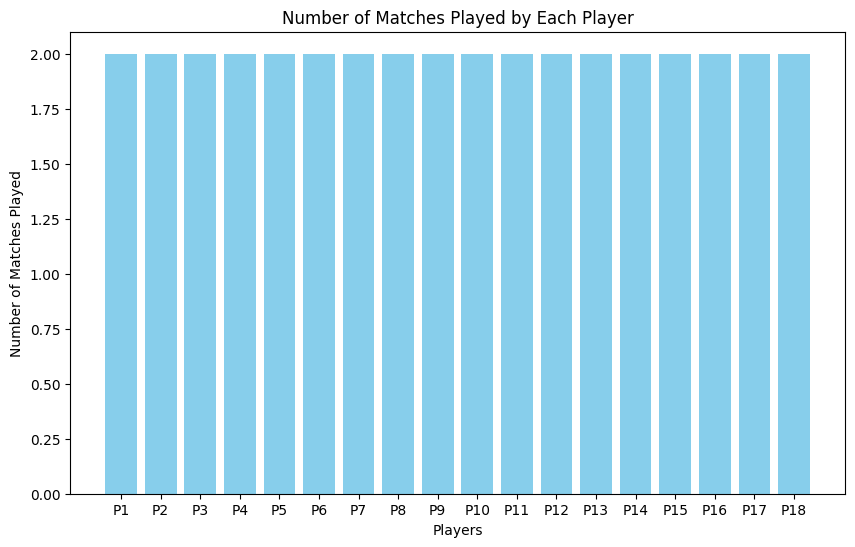

In [255]:
import matplotlib.pyplot as plt

# Extract players and match counts
player_matches = []
for player in PLAYERS_LIST:
    if player in list(matches_count.keys()):
        player_matches.append(matches_count[player])
    else:
        player_matches.append(0)


# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(PLAYERS_LIST, player_matches, color='skyblue')

# Add labels and title
plt.xlabel('Players')
plt.ylabel('Number of Matches Played')
plt.title('Number of Matches Played by Each Player')

# Display the chart
plt.show()

In [256]:
for i in range(ROUNDS):
    print(f'-----Round {i+1} ------')
    round = list_of_matches[i]
    for j in range(COURTS):
        print(f'---- court {j+1} ----')
        print(f'{round[j][0]}, rating {player_rankings_dict[round[j][0]]} and {round[j][1]}, rating {player_rankings_dict[round[j][1]]} vs {round[j][2]}, rating {player_rankings_dict[round[j][2]]} and {round[j][3]}, rating {player_rankings_dict[round[j][3]]}')
        print(f'Average rating {(player_rankings_dict[round[j][0]]+player_rankings_dict[round[j][1]])/2} vs {(player_rankings_dict[round[j][2]]+player_rankings_dict[round[j][3]])/2}')


-----Round 1 ------
---- court 1 ----
P16, rating 16 and P18, rating 18 vs P11, rating 11 and P4, rating 4
Average rating 17.0 vs 7.5
---- court 2 ----
P14, rating 14 and P8, rating 8 vs P12, rating 12 and P7, rating 7
Average rating 11.0 vs 9.5
---- court 3 ----
P3, rating 3 and P1, rating 1 vs P9, rating 9 and P13, rating 13
Average rating 2.0 vs 11.0
-----Round 2 ------
---- court 1 ----
P2, rating 2 and P5, rating 5 vs P6, rating 6 and P9, rating 9
Average rating 3.5 vs 7.5
---- court 2 ----
P10, rating 10 and P11, rating 11 vs P13, rating 13 and P14, rating 14
Average rating 10.5 vs 13.5
---- court 3 ----
P15, rating 15 and P16, rating 16 vs P17, rating 17 and P18, rating 18
Average rating 15.5 vs 17.5
-----Round 3 ------
---- court 1 ----
P1, rating 1 and P2, rating 2 vs P3, rating 3 and P4, rating 4
Average rating 1.5 vs 3.5
---- court 2 ----
P5, rating 5 and P6, rating 6 vs P7, rating 7 and P8, rating 8
Average rating 5.5 vs 7.5
---- court 3 ----
P10, rating 10 and P12, rating 

IndexError: list index out of range